<a href="https://colab.research.google.com/github/Srourrzan/AI_refresher/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr

In [9]:
import easyocr;
import cv2;
import sys;
import numpy as np;
import matplotlib.pyplot as plt;

In [15]:
class OCR:
  def __init__(self, languages: list = ['en']):
    self.__reader = easyocr.Reader(languages, gpu=False);
    return ;

  def preprocess_image(self, image_path: str) -> (np.ndarray, np.ndarray):
    image: np.ndarray = cv2.imread(image_path);
    if image is None:
      raise ValueError("Image not found at path.");
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY);
    return (image, gray_img);

  def extract_text(self, image_path: str) -> (np.ndarray, list):
    structured_data: list = [];
    original_img, processed_img = self.preprocess_image(image_path);
    results: list = self.__reader.readtext(processed_img);
    for (bbox, text, prob) in results:
      data: dict = {
          "text": text,
          "confidence": round(float(prob), 4),
          "bounding_box": [list(map(int, point)) for point in bbox]
      };
      structured_data.append(data);
    return (original_img, structured_data);

  def visualize(self, image: np.ndarray, results: list):
    bbox: list;

    for res in results:
      bbox = res["bounding_box"];
      top_left: tuple = tuple(bbox[0]);
      bottom_right: tuple = tuple(bbox[2]);
      cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2);
      cv2.putText(image, res["text"], (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color=(50, 255, 0), thickness=2);
    plt.figure(figsize=(10, 10));
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
    plt.axis("off");
    plt.show();

{'text': 'This is a lot of 12 point text to test the', 'confidence': 0.7515, 'bounding_box': [[33, 84], [587, 84], [587, 127], [33, 127]]}
{'text': 'ocr code and see if it works on', 'confidence': 0.9302, 'bounding_box': [[31, 121], [485, 121], [485, 157], [31, 157]]}
{'text': 'all types', 'confidence': 0.9978, 'bounding_box': [[495, 123], [625, 123], [625, 163], [495, 163]]}
{'text': 'of file format:', 'confidence': 0.7233, 'bounding_box': [[31, 154], [227, 154], [227, 191], [31, 191]]}
{'text': 'The quick brown dog jumped over the', 'confidence': 0.8491, 'bounding_box': [[32, 184], [592, 184], [592, 233], [32, 233]]}
{'text': 'lazy fox The quick brown dog jumped', 'confidence': 0.8124, 'bounding_box': [[29, 220], [591, 220], [591, 265], [29, 265]]}
{'text': 'over the lazy fox. The quick brown dog', 'confidence': 0.8062, 'bounding_box': [[31, 255], [605, 255], [605, 299], [31, 299]]}
{'text': 'jumped over the lazy fox. The quick', 'confidence': 0.596, 'bounding_box': [[39, 287], [568,

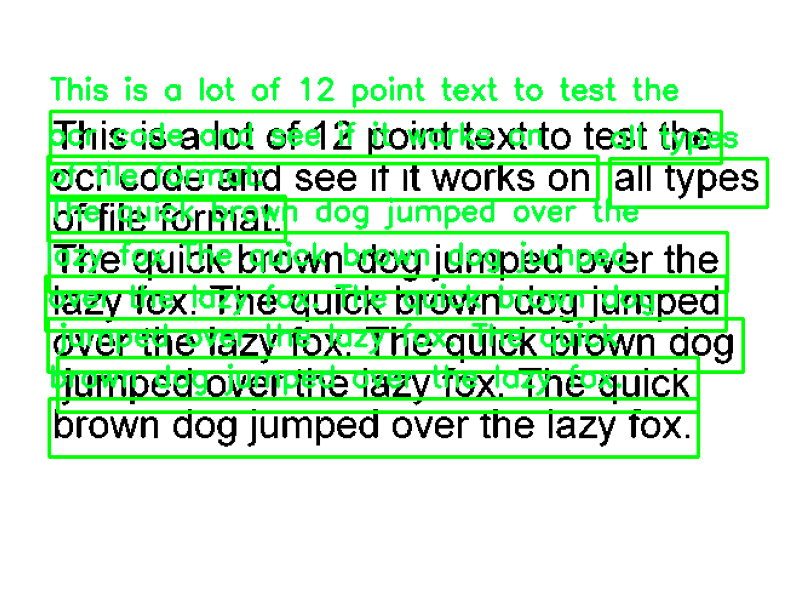

In [16]:
ocr: OCR = OCR();
img_path: str = "test-image-for-recognition.png";
try:
  img, ocr_res = ocr.extract_text(img_path);
  for d in ocr_res:
    print(f"{d}");
  ocr.visualize(img, ocr_res);
except Exception as e:
  print(f"Error: {e}", file=sys.stderr);

##### Testing code (building locgic)

image <class 'numpy.ndarray'>
gray <class 'numpy.ndarray'>


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
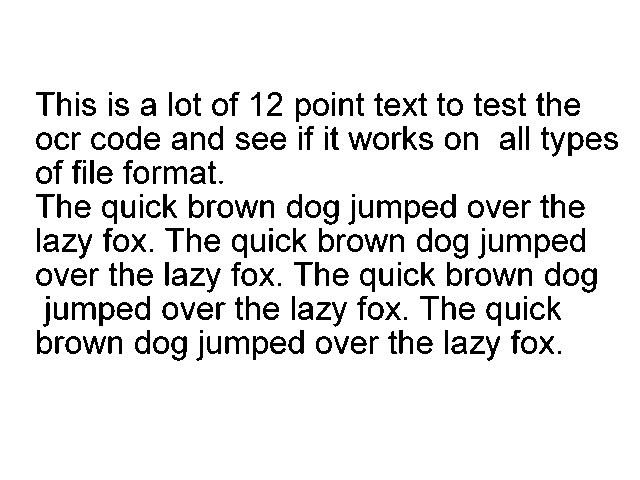

In [26]:
ocr: OCR = OCR();
img_path: str = "test-image-for-recognition.png";
image, gray = ocr.preprocess_image(img_path);
print(f"image {type(image)}");
print(f"gray {type(gray)}");
gray

In [27]:
results:list = ocr.extract_text(img_path);
results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[([[np.int32(33), np.int32(84)],
   [np.int32(587), np.int32(84)],
   [np.int32(587), np.int32(127)],
   [np.int32(33), np.int32(127)]],
  'This is a lot of 12 point text to test the',
  np.float64(0.7515471434680752)),
 ([[np.int32(31), np.int32(121)],
   [np.int32(485), np.int32(121)],
   [np.int32(485), np.int32(157)],
   [np.int32(31), np.int32(157)]],
  'ocr code and see if it works on',
  np.float64(0.9301597466870826)),
 ([[np.int32(495), np.int32(123)],
   [np.int32(625), np.int32(123)],
   [np.int32(625), np.int32(163)],
   [np.int32(495), np.int32(163)]],
  'all types',
  np.float64(0.9978408899985456)),
 ([[np.int32(31), np.int32(154)],
   [np.int32(227), np.int32(154)],
   [np.int32(227), np.int32(191)],
   [np.int32(31), np.int32(191)]],
  'of file format:',
  np.float64(0.7233347825715364)),
 ([[np.int32(32), np.int32(184)],
   [np.int32(592), np.int32(184)],
   [np.int32(592), np.int32(233)],
   [np.int32(32), np.int32(233)]],
  'The quick brown dog jumped over the',
  n

In [23]:
results[0][1], results[1][1], results[2][1], results[3][1]

('This is a lot of 12 point text to test the',
 'ocr code and see if it works on',
 'all types',
 'of file format:')

In [28]:
type(results[0][0]), type(results[0][1]), type(results[0][2])

(list, str, numpy.float64)

In [32]:
results[0][0]

[[np.int32(33), np.int32(84)],
 [np.int32(587), np.int32(84)],
 [np.int32(587), np.int32(127)],
 [np.int32(33), np.int32(127)]]

In [30]:
[list(map(int, point)) for point in results[0][0]]

[[33, 84], [587, 84], [587, 127], [33, 127]]

In [33]:
[list(map(float, point)) for point in results[0][0]]

[[33.0, 84.0], [587.0, 84.0], [587.0, 127.0], [33.0, 127.0]]

In [34]:
[list(map(str, point)) for point in results[0][0]]

[['33', '84'], ['587', '84'], ['587', '127'], ['33', '127']]

In [8]:
ocr.__reader

AttributeError: 'OCR' object has no attribute '__reader'